# MAIA Demo

#### Many of MAIA's experiments are available in the [experiment browser](https://multimodal-interpretability.csail.mit.edu/maia/experiment-browser/) ####

In [1]:
import os

import openai
from dotenv import load_dotenv

# Some imports require api key to be set ######
# Load environment variables
load_dotenv()

# Load OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.organization = os.getenv("OPENAI_ORGANIZATION")
###############################################


from maia_api import System, Tools, SyntheticSystem
from utils.DatasetExemplars import DatasetExemplars, SyntheticExemplars
from utils.main_utils import generate_save_path, create_bias_prompt, retrieve_synth_label
from utils.InterpAgent import InterpAgent
from utils.api_utils import str2image
from utils.ExperimentEnvironment import ExperimentEnvironment
from utils.call_agent import ask_agent
from IPython.display import clear_output


Stable-Diffusion 3.5 requires access to run. You can request it here: https://huggingface.co/stabilityai/stable-diffusion-3.5-medium

In [ ]:
# Login for access to sd-3.5
from huggingface_hub import login
login()

### Utils

In [2]:
# Plot the results from the experiment log
def plot_results_notebook(log_entry):
    if (log_entry['role'] == 'assistant'):
        print('\n\n*** MAIA: ***\n\n')  
    for item in log_entry['content']:
        if item['type'] == 'text':
            print(item['text'])
        elif item['type'] == 'image_url':
            display(str2image(item['image_url']['url'].split(',')[1]))

In [3]:
# MAIA's experiment loop, redefined here to display to the notebook after each step

class InterpAgentDemo(InterpAgent):
    def run_experiment(self, system: System, tools: Tools, save_html=False):
        """Runs the experiment loop. """

        # Make sure experiment log is clean
        self._init_experiment_log()
        experiment_env = ExperimentEnvironment(system, tools, globals())
        # Set Tools to point to this CodeAgent
        temp_agent, tools.agent = tools.agent, self
        # Experiment loop
        round_count = 0
        while True:
            round_count += 1
            model_experiment = ask_agent(self.model_name, self.experiment_log)
            self.update_experiment_log(role='model', type="text", type_content=str(model_experiment))
            # Plot the results from the experiment log
            clear_output()
            for log_entry in self.experiment_log:
                plot_results_notebook(log_entry)
            if save_html:
                tools.generate_html(self.experiment_log)
            if self.debug:
                print(model_experiment)
            
            if round_count > self.max_round_count:
                self._overload_instructions()
            else:
                if self.end_experiment_token in model_experiment:
                    break
                
                try:
                    experiment_output = experiment_env.execute_experiment(model_experiment)
                    if experiment_output != "":
                        self.update_experiment_log(role='user', type="text", type_content=experiment_output)
                except ValueError:
                    self.update_experiment_log(role='execution', 
                                               type="text", 
                                               type_content=f"No code to run was provided, please continue with the experiments based on your findings, or output your final {self.end_experiment_token}.")
        if save_html:
                tools.generate_html(self.experiment_log)
        
        # Restore tools to its original state
        tools.agent = temp_agent

### Arguments

In [4]:
maia_model = 'gpt-4o'
task = 'neuron_description'
n_exemplars = 15
model_name = "resnet152"
layer = "layer4"
neuron_num = 20
images_per_prompt = 1
path2save = '../results'
path2prompts = './prompts'
path2exemplars = './exemplars'
path2indices = './neuron_indices'
device = 0
text2image = 'sd'
debug = False

unit_config = {model_name: {layer: [neuron_num]}}

path2save = generate_save_path(path2save, maia_model, "test")
print(path2save)
os.makedirs(path2save, exist_ok=True)

../results/gpt-4o/test


### Initialize MAIA

In [5]:
# Prompt needs to be created dynamically for bias_discovery so class label can be inserted
if task == "bias_discovery":
    create_bias_prompt(path2indices, path2prompts, str(neuron_num))

# Add API configuration [(class, [methods])]
api = [
    (System, [System.call_neuron]),
    (Tools, [Tools.text2image, Tools.edit_images, Tools.dataset_exemplars, 
             Tools.display, Tools.describe_images, Tools.summarize_images])
]
maia = InterpAgentDemo(
    model_name=maia_model,
    api=api,
    prompt_path=path2prompts,
    api_prompt_name="api.txt",
    user_prompt_name=f"user_{task}.txt",
    overload_prompt_name="final.txt",
    end_experiment_token="[DESCRIPTION]",
    max_round_count=15,
    debug=debug
)
if model_name == "synthetic":
    net_dissect = SyntheticExemplars(
        os.path.join(path2exemplars, model_name),
        path2save,
        layer
    )
    gt_label = retrieve_synth_label(layer, neuron_num)
    system = SyntheticSystem(neuron_num, gt_label, layer, device)
else:
    net_dissect = DatasetExemplars(
        path2exemplars,
        n_exemplars,
        path2save,
        unit_config
    )
    system = System(model_name, layer, neuron_num, net_dissect.thresholds, device)

tools = Tools(
    path2save,
    device,
    maia,
    system,
    net_dissect,
    images_per_prompt=images_per_prompt,
    text2image_model_name=text2image,
    image2text_model_name=maia_model
)

print("HTML path: ", tools.html_path)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

HTML path:  ../results/gpt-4o/test/experiment_4.html


## Maia's api and user prompts

In [6]:
plot_results_notebook(maia.experiment_log[0])
plot_results_notebook(maia.experiment_log[1])

Class System:
    A Python class containing the vision model and the specific neuron to interact with.
    
    Attributes
    ----------
    neuron_num : int
        The unit number of the neuron.
    layer : string
        The name of the layer where the neuron is located.
    model_name : string
        The name of the vision model.
    model : nn.Module
        The loaded PyTorch model.
    
    Methods
    -------
    call_neuron(image_list: List[torch.Tensor]) -> Tuple[List[int], List[str]]
        Returns the neuron activation for each image in the input image_list as well as the original image (encoded into a Base64 string).

    def call_neuron(self, image_list: List[torch.Tensor]) -> Tuple[List[float], List[str]]:
        The function returns the neuron's maximum activation value (in int format) for each of the images in the list as well as the original image (encoded into a Base64 string).
        
        Parameters
        ----------
        image_list : List[torch.Tensor]

## Experiment

Class System:
    A Python class containing the vision model and the specific neuron to interact with.
    
    Attributes
    ----------
    neuron_num : int
        The unit number of the neuron.
    layer : string
        The name of the layer where the neuron is located.
    model_name : string
        The name of the vision model.
    model : nn.Module
        The loaded PyTorch model.
    
    Methods
    -------
    call_neuron(image_list: List[torch.Tensor]) -> Tuple[List[int], List[str]]
        Returns the neuron activation for each image in the input image_list as well as the original image (encoded into a Base64 string).

    def call_neuron(self, image_list: List[torch.Tensor]) -> Tuple[List[float], List[str]]:
        The function returns the neuron's maximum activation value (in int format) for each of the images in the list as well as the original image (encoded into a Base64 string).
        
        Parameters
        ----------
        image_list : List[torch.Tensor]

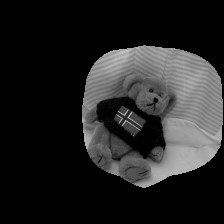

Activation: 17.52


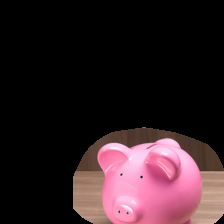

Activation: 17.1


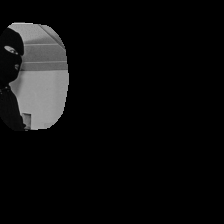

Activation: 16.06


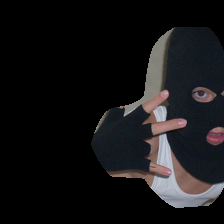

Activation: 15.57


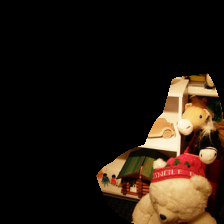

Activation: 14.68


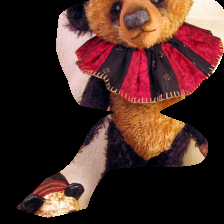

Activation: 14.34


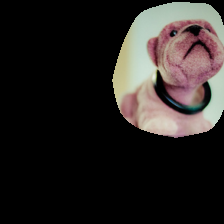

Activation: 14.32


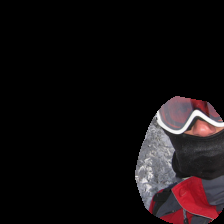

Activation: 14.27


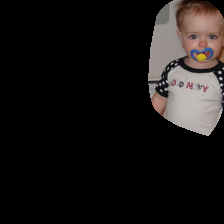

Activation: 14.22


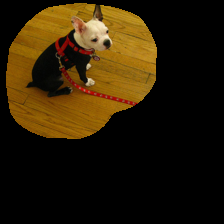

Activation: 14.15


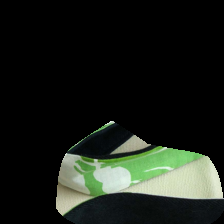

Activation: 13.72


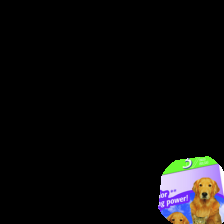

Activation: 13.66


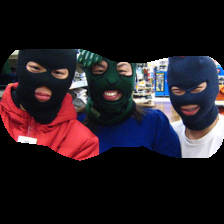

Activation: 13.47


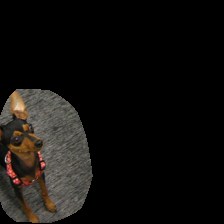

Activation: 13.3


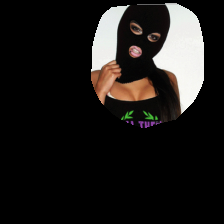

Activation: 13.25


*** MAIA: ***


**Observations:**
The images with high activation values include:
- Teddy bears.
- People wearing masks/balaclavas.
- Dogs, especially with accessories or clothing.
- Other stuffed animals or toys.

**Initial Hypotheses:**
1. The neuron may be selective for stuffed animals or toys.
2. The neuron may be responsive to masks or features resembling a face but obscured.
3. The neuron might be activated by animals, particularly those with facial features or accessories.
4. There may be a focus on children's imagery or items associated with children (e.g., toys, colorful items).

Let's proceed to test these hypotheses further using targeted image generation and editing.

[CODE]:

```python
# Generate images based on key elements found in the initial observations
prompts = [
    "a teddy bear in a playground",
    "a dog wearing a hat",
    "a person wearing a balaclava in the snow",
    "a clown holding a stuffed toy",
    "a plush toy showcase"
]

# Genera

In [7]:
# Run full experiment
maia.run_experiment(system, tools, save_html=True)

### Manual Experiment
To manually run experiment steps, run these cells. 

In [8]:
# To reset maia's experiment log to just the api and user prompt, run
maia._init_experiment_log()
experiment_env = ExperimentEnvironment(system, tools, globals())

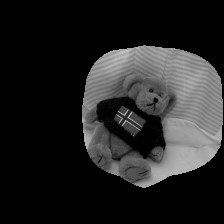

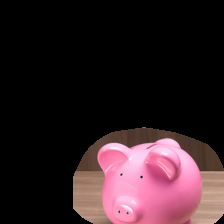

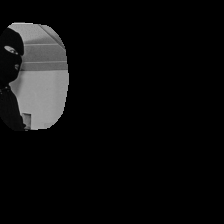

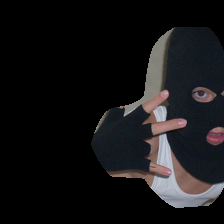

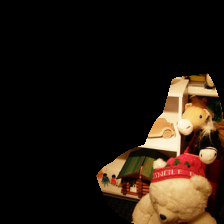

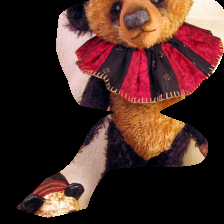

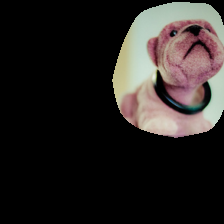

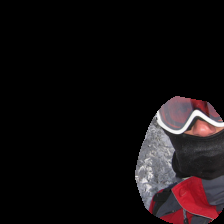

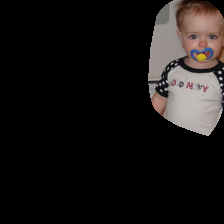

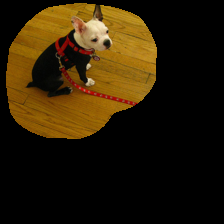

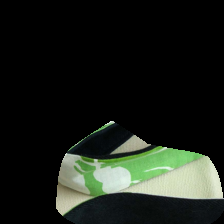

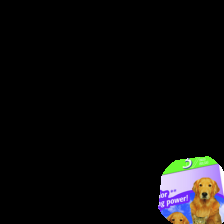

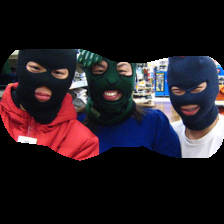

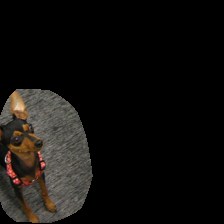

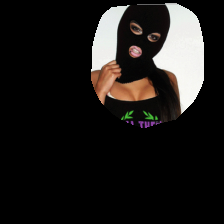

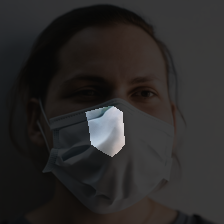

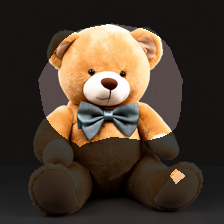

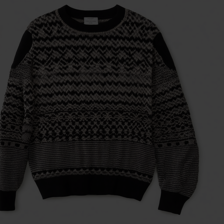

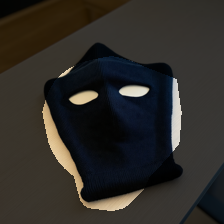

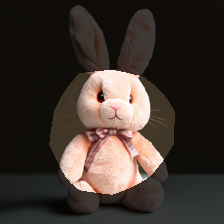

In [10]:
# Run this cell repeatedly to iterate through experiment
model_experiment = ask_agent(maia.model_name, maia.experiment_log)
experiment_output = experiment_env.execute_experiment(model_experiment)
maia.update_experiment_log(role='user', type="text", type_content=experiment_output)
# Plot the results from the experiment log
clear_output()
for log_entry in maia.experiment_log:
    plot_results_notebook(log_entry)